# 3.3/4/5 Impact/Comparison/Dealing

Sections covered:
- 3.3: Impact of detours on the solver’s total length
- 3.4: Comparison of B&C and HGS solutions
- 3.5: Dealing with crossings from HGS-CVRP

This is used in the paper **Flexible cable routing framework for wind farm collection system optimization**.

## Preamble

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import polars as pl

In [3]:
from optiwindnet.db import modelv2
from optiwindnet.db.storagev2 import G_from_routeset
from optiwindnet.svg import svgplot

In [4]:
plt.style.use('jupyter_dark')

In [5]:
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

## Setup

In [6]:
db = modelv2.open_database('data/paperdb.v2.sqlite')

## Selecting *actual* routesets

In [7]:
Ns_q = db.NodeSet.select(
    lambda ns:
    ns.name[0] != '!'
)
Ns_q.count()

69

In [8]:
entries = []
for ns in Ns_q:
    for rs in ns.RouteSets:
        entries.append((
            ns.name,
            rs.id,
            ns.T,
            rs.capacity,
            rs.detextra,
            rs.length,
            rs.creator,
            rs.misc.get('gap', None),
        ))
len(entries)

1464

### Make DataFrame

In [9]:
schema_actual = dict(
    name=str,
    id=int,
    T=int,
    capacity=int,
    detextra=float,
    length=float,
    creator=str,
    gap=float,
)

In [10]:
df_actual = pl.DataFrame(entries, schema=schema_actual, orient='row')

In [11]:
df_actual

name,id,T,capacity,detextra,length,creator,gap
str,i64,i64,i64,f64,f64,str,f64
"""Gode Wind 1""",3,55,6,null,59109.208596,"""MILP.pyomo.cplex""",0.005
"""Gode Wind 1""",202,55,3,0.006098,86692.324884,"""MILP.pyomo.cplex""",0.002397
"""Gode Wind 1""",4153,55,6,null,59786.62999,"""baselines.hgs""",null
"""Gode Wind 1""",7,55,11,null,49899.074128,"""MILP.pyomo.cplex""",0.004998
"""Gode Wind 1""",3620,55,11,null,51682.477491,"""baselines.hgs""",null
…,…,…,…,…,…,…,…
"""Cazzaro-2022""",21618,50,8,0.02092,8.943844,"""baselines.hgs""",null
"""Cazzaro-2022""",21627,50,7,0.001865,8.730934,"""MILP.pyomo.cplex""",0.004998
"""Cazzaro-2022""",21621,50,11,-1.1102e-16,7.753919,"""baselines.hgs""",null


In [12]:
df_actual['name'].value_counts()

name,count
str,u32
"""Shengsi 2""",22
"""Global Tech 1""",22
"""Gemini 1""",22
"""Merkur""",22
"""Rødsand 2""",22
…,…
"""Dudgeon""",22
"""Moray East.1_OSS""",22
"""Arkona""",22


In [13]:
df_actual['gap'].max()

0.019817266284630097

In [14]:
df_actual['detextra'].max()

0.12263549531666174

In [14]:
df_actual['detextra'].max()

0.07397519014347398

### group ⟨heuri, exact⟩ pairs

In [15]:
pairs_actual = []
for ns in Ns_q:
    dfn = df_actual.filter(pl.col('name') == ns.name)
    for k in range(dfn['capacity'].min(), dfn['capacity'].max() + 1):
        dfk = dfn.filter(pl.col('capacity') == k)
        if dfk.height >= 2:
            mask = pl.col('creator') == 'baselines.hgs'
            heuri = dfk.filter(mask).bottom_k(1, by='length')[0]
            exact = dfk.filter(~mask).bottom_k(1, by='gap')[0]
            if exact['gap'].item() <= 0.02:
                pairs_actual.append((db.RouteSet[heuri['id'].item()],
                                     db.RouteSet[exact['id'].item()]))
len(pairs_actual)

732

In [16]:
diffs = []
for rs_hgs, rs_bnc in pairs_actual:
    diffs.append(rs_hgs.length/rs_bnc.length - 1)

In [17]:
for (heuri, exact), diff in zip(pairs_actual, diffs):
    if diff >= 0.07:
        print(heuri.id, exact.id, exact.nodes.name)

21311 22196 Sandbank
21545 21925 Moray West.1_OSS


In [18]:
small_diffs = []
for (heuri, exact), diff in zip(pairs_actual, diffs):
    if diff <= 0.01:
        small_diffs.append((heuri.id, exact.id))
len(small_diffs)

540

0.07397519014347398


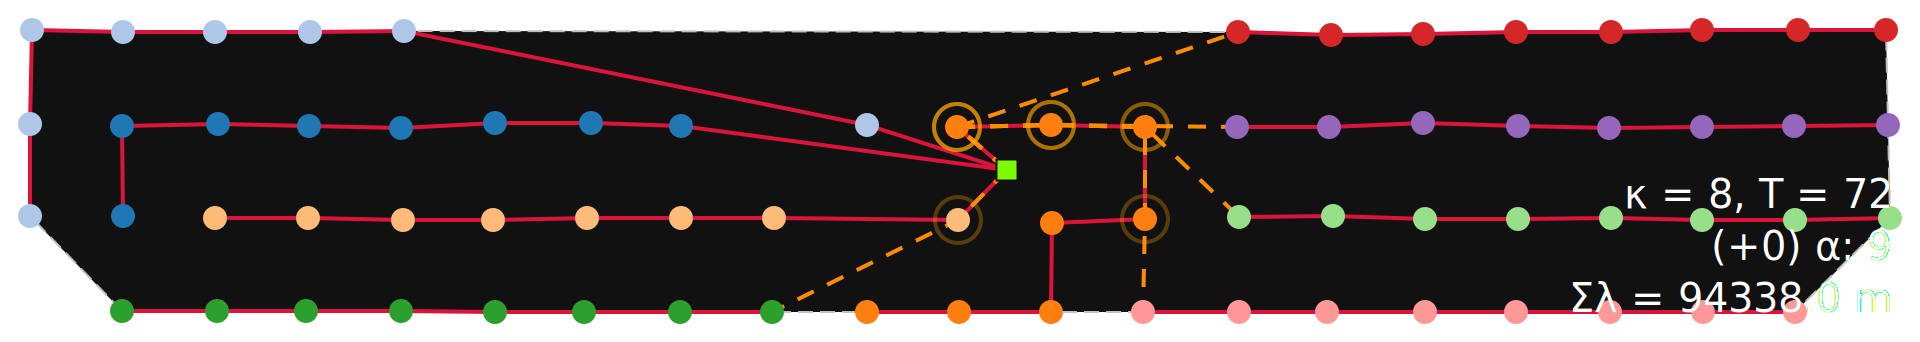

In [19]:
rs = db.RouteSet[21311]
print(rs.detextra)
svgplot(G_from_routeset(rs))

0.0013995437575948788


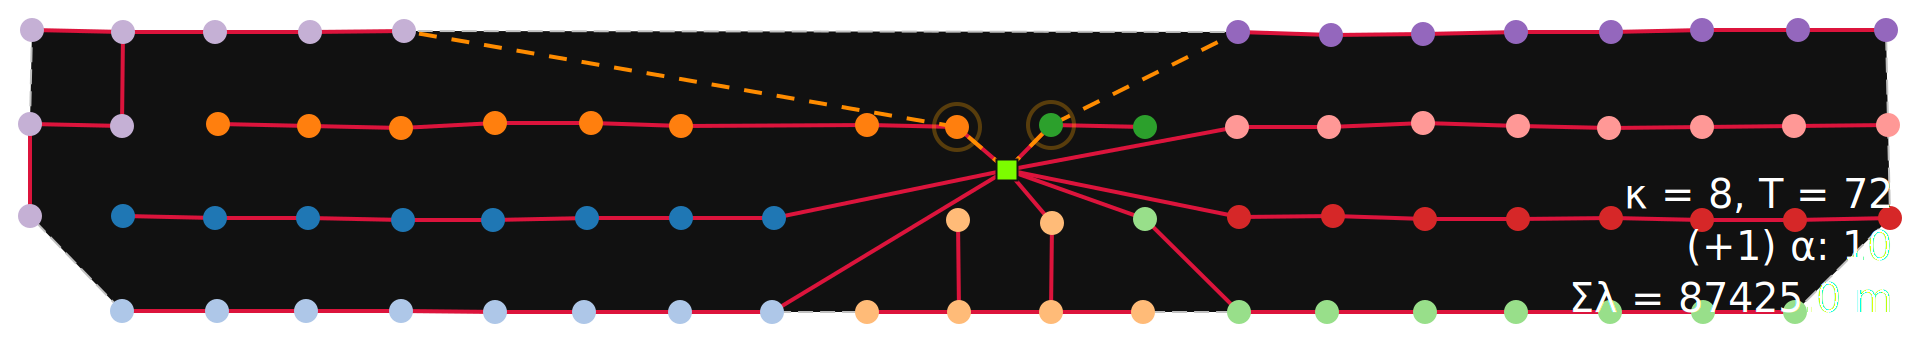

In [20]:
rs = db.RouteSet[22196]
print(rs.detextra)
svgplot(G_from_routeset(rs))

0.02038470064164777


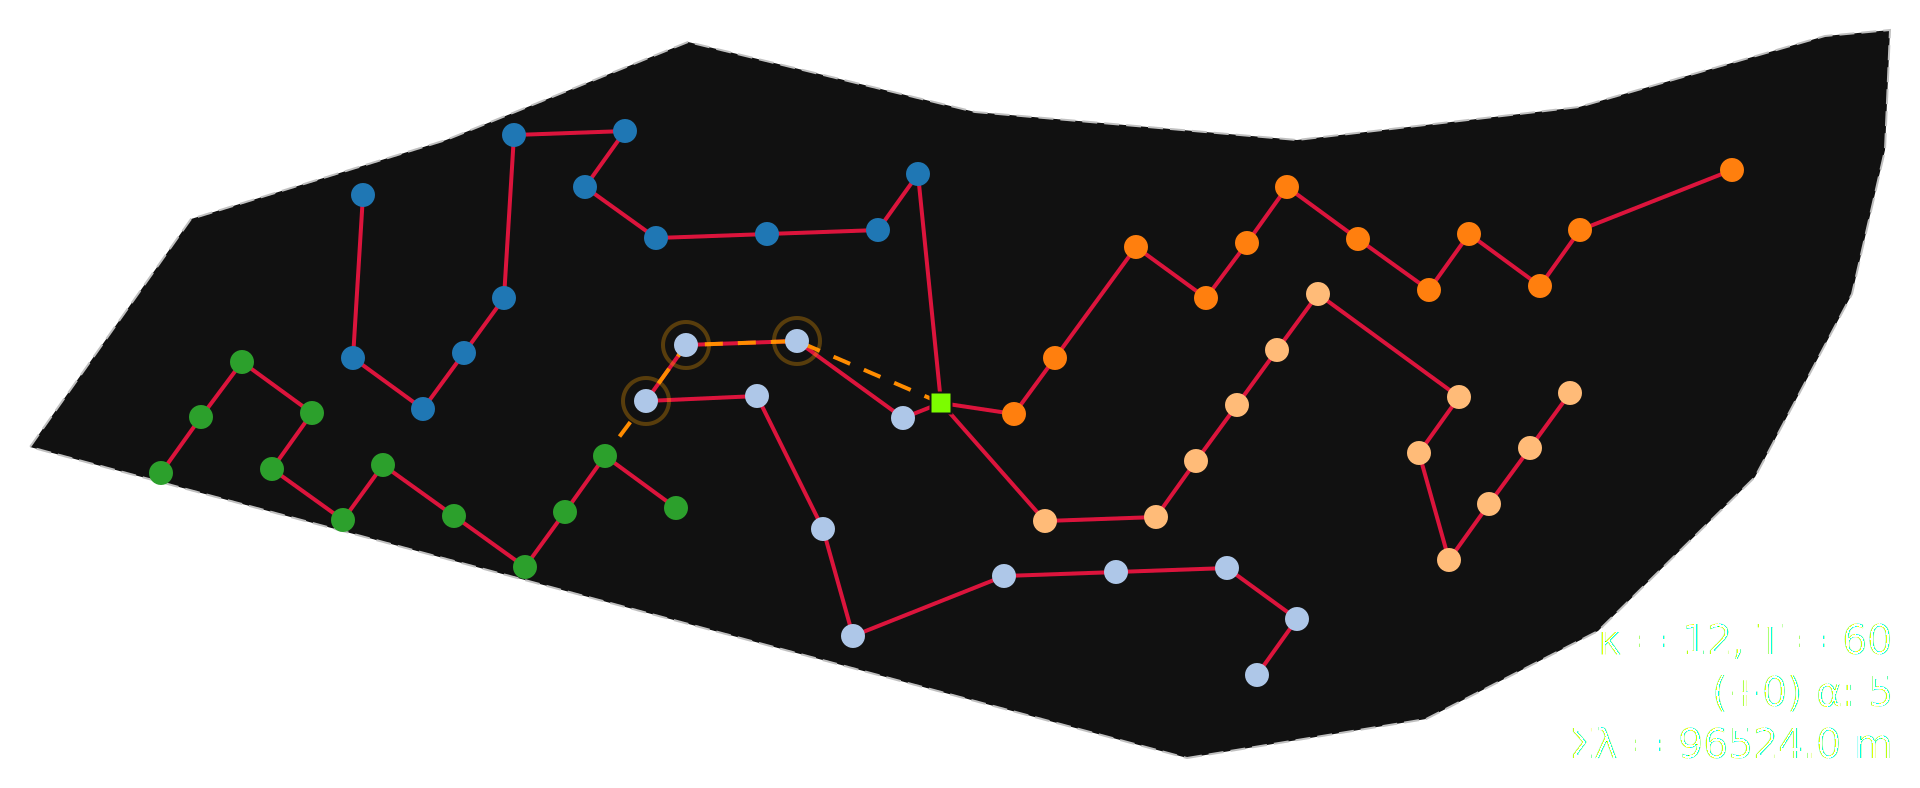

In [21]:
rs = db.RouteSet[21545]
print(rs.detextra)
svgplot(G_from_routeset(rs))

None


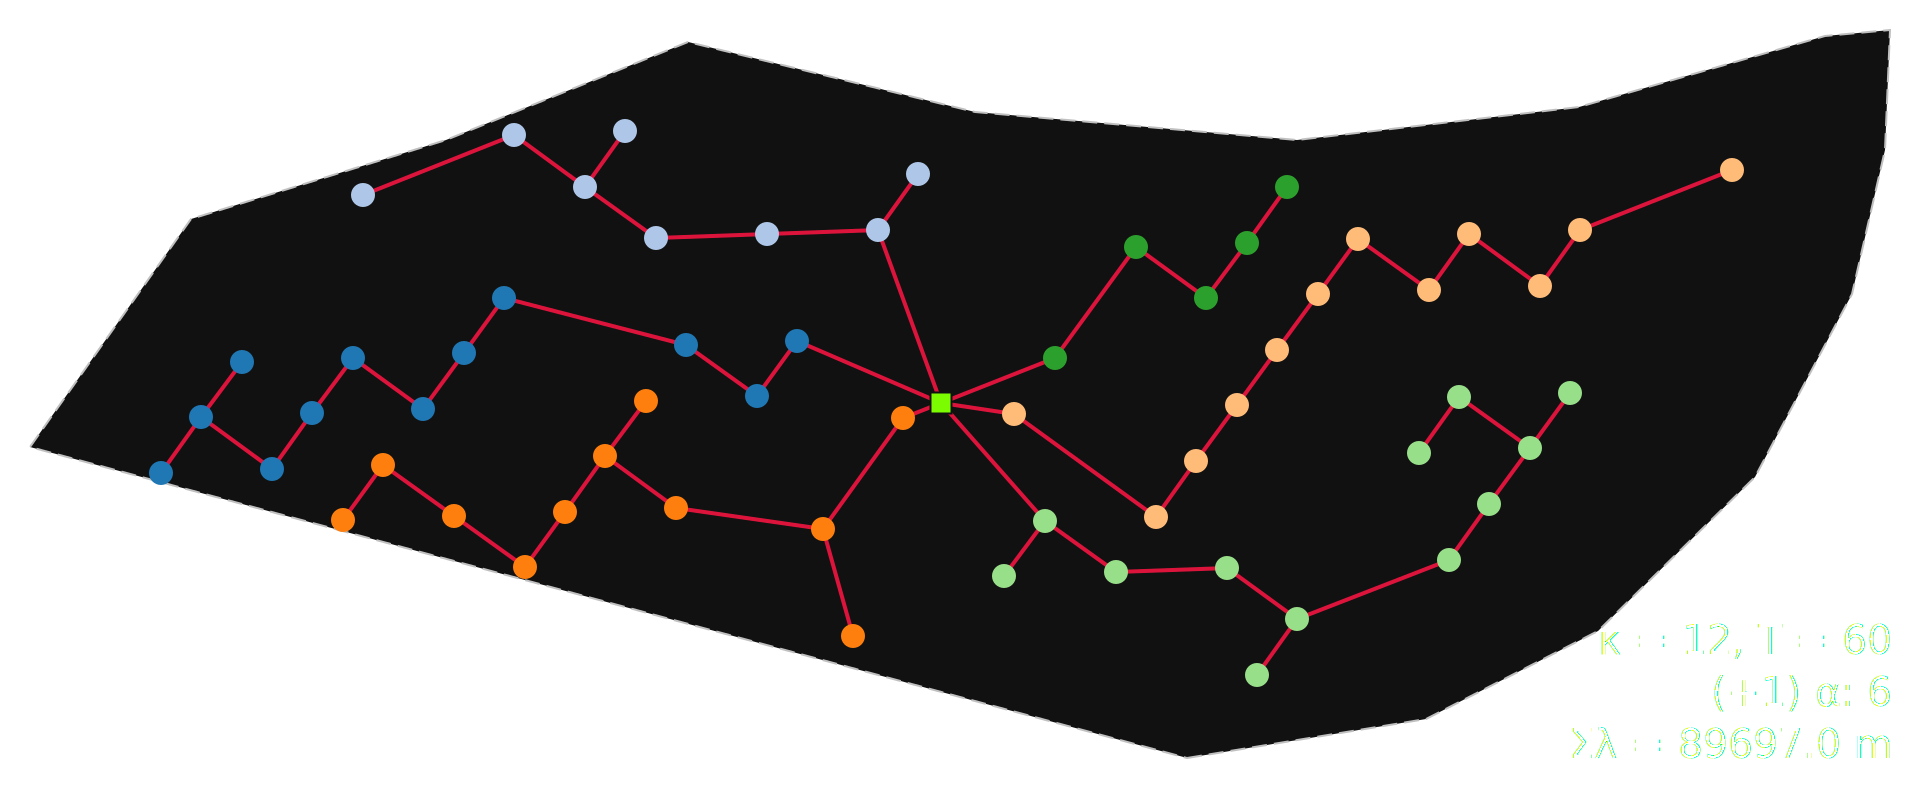

In [22]:
rs = db.RouteSet[21925]
print(rs.detextra)
svgplot(G_from_routeset(rs))

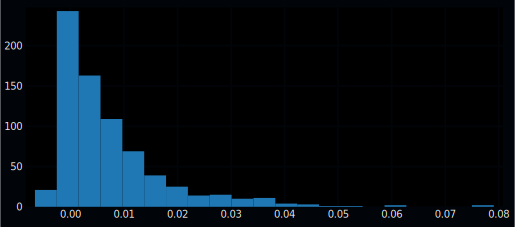

In [23]:
plt.hist(diffs, bins=21);

## HGS optimizer

### Select HGS-CVRP entries

In [24]:
method_hgs = db.Method.select(
    lambda m:
    m.funname == 'hgs_cvrp'
    and m.options['timeLimit'] == 120
)
method_hgs.count()

2

In [25]:
for m in method_hgs:
    print(m.funname, m.options)

hgs_cvrp {'complete': False, 'lambda_': 40, 'mu': 25, 'nbClose': 5, 'nbElite': 4, 'nbGranular': 20, 'nbIter': 20000, 'scale': 10000.0, 'seed': 0, 'targetFeasible': 0.2, 'timeLimit': 120.0, 'useSwapStar': True}
hgs_cvrp {'complete': False, 'lambda_': 40, 'mu': 25, 'nbClose': 5, 'nbElite': 4, 'nbGranular': 20, 'nbIter': 20000, 'seed': 20241113, 'targetFeasible': 0.2, 'timeLimit': 120, 'useSwapStar': True}


### synthetic instances (a single capacity per NodeSet)

In [26]:
pairs_synth = []

In [27]:
# hgs instances that were first solved by cplex
hgs_sub2 = db.RouteSet.select(
    lambda rs:
    rs.method in method_hgs
    and 'solver_details' in rs.misc
    and 'incumbent_id' in rs.misc['solver_details']
    and rs.valid is None
    # and rs.nodes.name != 'Ormonde'
    and rs.nodes.name[0] == '!'
    and rs.T >= 50
)
# keep only instances for which the exact solution is within 2% gap
for rs_hgs in hgs_sub2:
    rs_bnc = db.RouteSet[rs_hgs.misc['solver_details']['incumbent_id']]
    # if rs_bnc.misc['bound']/rs_bnc.length >= 0.98:
    if rs_bnc.misc['gap'] <= 0.02:
        pairs_synth.append((rs_hgs, rs_bnc))
hgs_sub2.count(), len(pairs_synth)

(2346, 2346)

In [28]:
# hgs instances that were solved by cplex afterward
hgs_sub2_ = db.RouteSet.select(
    lambda rs:
    rs.method in method_hgs
    and 'solver_details' not in rs.misc
    and rs.valid is None
    and rs.nodes.name[0] == '!'
    and rs.T >= 50
)
# keep only instances for which the exact solution is within 2% gap
for rs_hgs in hgs_sub2_:
    if len(rs_hgs.nodes.RouteSets) == 1:
        # no MILP counterpart
        continue
    cplex = gurobi = None
    for rs2 in rs_hgs.nodes.RouteSets:
        if rs2 is rs_hgs:
            continue
        if rs2.creator == 'MILP.pyomo.cplex':
            cplex = rs2
        elif rs2.creator == 'MILP.pyomo.gurobi':
            gurobi = rs2
    if gurobi and gurobi.misc['gap'] <= 0.02:
        pairs_synth.append((rs_hgs, gurobi))
    elif cplex and cplex.misc['gap'] <= 0.02:
        pairs_synth.append((rs_hgs, cplex))
hgs_sub2_.count(), len(pairs_synth)

(4033, 6379)

In [29]:
len(pairs_actual) + len(pairs_synth)

7111

### Check if there are NodeSets counted multiple times

In [30]:
len(pairs_synth)

6379

In [31]:
once = set()
twice = set()
for rs_hgs, rs_bnc in pairs_synth:
    assert rs_hgs.nodes is rs_bnc.nodes, (rs_hgs.nodes.name, rs_bnc.nodes.name)
    if rs_hgs.nodes.digest in once:
        if rs_hgs.nodes.digest in twice:
            print(f'more than twice: {rs_hgs.nodes.name}')
        twice.add(rs_hgs.nodes.digest)
    else:
        once.add(rs_hgs.nodes.digest)
len(once), len(twice)

(6379, 0)

### Make DataFrame

In [32]:
schema_hgs = dict(
    id=int,
    synthetic=bool,
    T=int,
    capacity=int,
    detextra=float,
    length=float,
    # incumbent=float,
    # incumbent_bound=float,
    exact_bound=float,
    # incumbent_id=int,
)

In [33]:
data = []
for rs_hgs, rs_bnc in pairs_actual + pairs_synth:
    data.append(dict(
        id=rs_hgs.id,
        synthetic=rs_hgs.nodes.name[0] == '!',
        T=rs_hgs.T,
        capacity=rs_hgs.capacity,
        detextra=rs_hgs.detextra,
        length=rs_hgs.length,
        exact_bound=rs_bnc.misc['bound'],
    ))
    # print(details['incumbent_id'], end=' ')
df_hgs = pl.DataFrame(data, schema=schema_hgs)

In [34]:
df_hgs.columns

['id', 'synthetic', 'T', 'capacity', 'detextra', 'length', 'exact_bound']

In [35]:
df_hgs['synthetic'].value_counts()

synthetic,count
bool,u32
false,732
true,6379


In [36]:
df_hgs['detextra'].describe()

statistic,value
str,f64
"""count""",5129.0
"""null_count""",1982.0
"""mean""",0.003079
"""std""",0.005495
"""min""",-0.018452
"""25%""",0.000774
"""50%""",0.001803
"""75%""",0.003515
"""max""",0.118956


In [37]:
detextra_hgs = np.sort(np.nan_to_num(np.clip(df_hgs['detextra'], 0., None), nan=0.))

In [38]:
# Negative detextra in hgs is OK.
# It means some subtree roots chosen by PathFinder were closer to root
# than the path's head (since PathFinder relaxes the path-subtree constraint)
df_hgs.filter(pl.col('detextra') < -1e-3)

id,synthetic,T,capacity,detextra,length,exact_bound
i64,bool,i64,i64,f64,f64,f64
21006,false,60,10,-0.002975,51296.546654,49611.477292
21209,false,55,2,-0.003444,182175.265645,182804.81475
21208,false,55,4,-0.001266,99909.593562,99531.718807
21556,false,119,2,-0.017189,405793.043417,412587.411775
21557,false,119,3,-0.007867,291621.821448,292531.694887
…,…,…,…,…,…,…
16186,true,70,10,-0.009745,7.983239,7.73576
16857,true,50,4,-0.003896,8.106149,8.051141
17139,true,133,10,-0.002333,12.255932,11.63741


## B&C solver

### Make DataFrame

In [39]:
schema_exact = dict(
    id=int,
    synthetic=bool,
    T=int,
    capacity=int,
    detextra=float,
    length=float,
    bound=float,
)

In [40]:
data = []
for rs_hgs, rs_bnc in pairs_actual + pairs_synth:
    data.append(dict(
        id=rs_bnc.id,
        synthetic=rs_bnc.nodes.name[0] == '!',
        T=rs_bnc.T,
        capacity=rs_bnc.capacity,
        detextra=rs_bnc.detextra,
        length=rs_bnc.length,
        bound=rs_bnc.misc['bound'],
    ))
df_BnC = pl.DataFrame(data, schema=schema_exact)

In [41]:
df_BnC.height

7111

In [42]:
df_BnC['detextra'].describe()

statistic,value
str,f64
"""count""",4949.0
"""null_count""",2162.0
"""mean""",0.002359
"""std""",0.004466
"""min""",-0.009212
"""25%""",0.000637
"""50%""",0.001591
"""75%""",0.003006
"""max""",0.122635


In [43]:
detextra_BnC = np.sort(np.nan_to_num(np.clip(df_BnC['detextra'], 0., None), nan=0.))

## 3.3 Impact of detours on the solver's total length

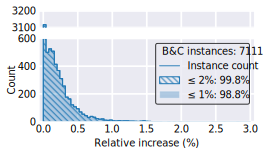

In [45]:
with plt.style.context('pdf_1col'):
    data = 100*detextra_BnC

    fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[1, 5], figsize=(3.5, 2),
                                   facecolor='w', sharex=True)
    # fig.subplots_adjust(hspace=0.05)
    ax1.spines.bottom.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)
    num_data = len(data)
    below1 = data <= 1
    below2 = data <= 2
    bins = np.linspace(0, 3, num=76)
    # bins = None

    # top y_axis segment
    H1, X1, art1_ = ax1.hist(data[below1], bins = bins, color='tab:blue',
                             histtype='stepfilled', alpha=0.3)
    H2, X2, art2_ = ax1.hist(data[below2], bins = bins, edgecolor='tab:blue',
                             histtype='stepfilled', hatch=r'\\\\', facecolor='none')
    H, X, art_ = ax1.hist(data, bins = bins, color='tab:blue', histtype='step')

    # main y_axis segment
    H1, X1, art1_ = ax2.hist(data[below1], bins = bins, color='tab:blue',
                             histtype='stepfilled', alpha=0.3)
    H2, X2, art2_ = ax2.hist(data[below2], bins = bins, edgecolor='tab:blue',
                             histtype='stepfilled', hatch=r'\\\\', facecolor='none')
    H, X, art_ = ax2.hist(data, bins = bins, color='tab:blue', histtype='step')

    ax1.set_ylim(3100, 3200)  # outliers only
    ax2.set_ylim(0, 600)  # most of the data

    C1, C2 = H1.sum(), H2.sum()
    leg = ax2.legend(  # the empty Line2D is a hack to get a line instead of a patch
        [Line2D([], []), art2_[0], art1_[0]],
        ['Instance count',
         f'≤ 2%: {100*C2/num_data:.1f}%',
         f'≤ 1%: {100*C1/num_data:.1f}%'],
        title=f'B&C instances: {num_data}'
    )
    ax2.set_ylabel('Count')
    ax2.set_xlabel('Relative increase (%)')
    leg.legend_handles[0] = Line2D([], [])
    ax1.figure.savefig('fig_detextra_BnC.pdf', transparent=False)
    pass

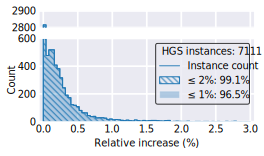

In [46]:
with plt.style.context('pdf_1col'):
# with plt.style.context('pub_paperfarm'):
# if True:
    data = 100*detextra_hgs

    fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[1, 5], figsize=(3.5, 2),
                                   facecolor='w', sharex=True)
    # fig.subplots_adjust(hspace=0.05)
    ax1.spines.bottom.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)
    num_data = len(data)
    below1 = data <= 1
    below2 = data <= 2
    bins = np.linspace(0, 3, num=76)
    # bins = None

    # top y_axis segment
    H1, X1, art1_ = ax1.hist(data[below1], bins = bins, color='tab:blue',
                             histtype='stepfilled', alpha=0.3)
    H2, X2, art2_ = ax1.hist(data[below2], bins = bins, edgecolor='tab:blue',
                             histtype='stepfilled', hatch=r'\\\\', facecolor='none')
    H, X, art_ = ax1.hist(data, bins = bins, color='tab:blue', histtype='step')

    # main y_axis segment
    H1, X1, art1_ = ax2.hist(data[below1], bins = bins, color='tab:blue',
                             histtype='stepfilled', alpha=0.3)
    H2, X2, art2_ = ax2.hist(data[below2], bins = bins, edgecolor='tab:blue',
                             histtype='stepfilled', hatch=r'\\\\', facecolor='none')
    H, X, art_ = ax2.hist(data, bins = bins, color='tab:blue', histtype='step')

    ax1.set_ylim(2800, 2900)  # outliers only
    ax2.set_ylim(0, 600)  # most of the data

    C1, C2 = H1.sum(), H2.sum()
    leg = ax2.legend(  # the empty Line2D is a hack to get a line instead of a patch
        [Line2D([], []), art2_[0], art1_[0]],
        ['Instance count',
         f'≤ 2%: {100*C2/num_data:.1f}%',
         f'≤ 1%: {100*C1/num_data:.1f}%'],
        title=f'HGS instances: {num_data}'
    )
    ax2.set_ylabel('Count')
    ax2.set_xlabel('Relative increase (%)')
    leg.legend_handles[0] = Line2D([], [])
    ax1.figure.savefig('fig_detextra_HGS.pdf', transparent=False)
    pass

## 3.4 Comparison of B&C and HGS solutions

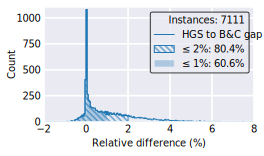

In [47]:
with plt.style.context('pdf_1col'):
    data_HGSvsBnC_gap = 1 - df_BnC['length']/df_hgs['length']
    data = 100*data_HGSvsBnC_gap.to_numpy()

    fig, ax = plt.subplots(facecolor='w', figsize=(3.5, 2))
    num_data = len(data)
    below1 = data <= 1
    below2 = data <= 2
    elsewhere = data > 2
    bins = np.linspace(-2, 8, num=201)

    # main y_axis segment
    H1, X1, art1_ = ax.hist(data[below1], bins = bins, color='tab:blue',
                             histtype='stepfilled', alpha=0.3)
    H2, X2, art2_ = ax.hist(data[below2], bins = bins, edgecolor='tab:blue',
                             histtype='stepfilled', hatch=r'\\\\', facecolor='none')
    H, X, art_ = ax.hist(data, bins = bins, color='tab:blue', histtype='step')

    C1, C2 = H1.sum(), H2.sum()
    leg = ax.legend(  # the empty Line2D is a hack to get a line instead of a patch
        [Line2D([], []), art2_[0], art1_[0]],
        ['HGS to B&C gap',
         f'≤ 2%: {100*C2/num_data:.1f}%',
         f'≤ 1%: {100*C1/num_data:.1f}%'],
        title=f'Instances: {num_data}'
    )
    ax.set_ylabel('Count')
    ax.set_xlabel('Relative difference (%)')
    leg.legend_handles[0] = Line2D([], [])
    ax.set_xlim(-2, 8)
    ax.figure.savefig('fig_HGS_to_BnC_gap.pdf', transparent=False)
    pass

## 3.5 Dealing with crossings from HGS-CVRP

### Select HGS-CVRP entries

In [48]:
df_hgs.height

7111

In [49]:
method_hgs = db.Method.select(
    lambda m:
    m.funname == 'hgs_cvrp'
    and m.options['timeLimit'] == 120
)

In [50]:
method_hgs.count()

2

In [51]:
hgs_all = db.RouteSet.select(
    lambda rs:
    rs.method in method_hgs
)
hgs_all.count()

7044

In [52]:
hgs_invalid = hgs_all.filter(
    lambda rs:
    rs.valid is False
)
hgs_invalid.count()

0

In [53]:
# just the instances repaired after the first hgs run
hgs_repaired = hgs_all.filter(
    lambda rs:
    rs.valid is None  # provisory valid marker
    and 'repaired' in rs.misc
    and 'hgs_reruns' not in rs.misc
)
hgs_repaired.count()

332

In [54]:
hgs_reruns = hgs_all.filter(
    lambda rs:
    rs.valid is None  # provisory valid marker
    and 'hgs_reruns' in rs.misc
)
hgs_reruns.count()

98

### Statistics

In [55]:
hgs_all = db.RouteSet.select(
    lambda rs:
    rs.creator == 'baselines.hgs'
    # rs.method.solver_name == 'HGS-CVRP'
    # and rs.method.options['timeLimit'] == 120
)
hgs_all.count()

7111

In [56]:
# just the instances repaired after the first hgs run
hgs_repaired = hgs_all.filter(
    lambda rs:
    rs.valid is None  # provisory valid marker
    and 'repaired' in rs.misc
    and 'hgs_reruns' not in rs.misc
)
hgs_repaired.count()

332

In [57]:
hgs_reruns = hgs_all.filter(
    lambda rs:
    rs.valid is None  # provisory valid marker
    and 'hgs_reruns' in rs.misc
)
hgs_reruns.count()

98

In [58]:
(hgs_repaired.count() + hgs_reruns.count())/hgs_all.count()

0.06046969483898186

In [59]:
hgs_repaired.count()/hgs_all.count()

0.04668822950358599

In [60]:
hgs_reruns.count()/hgs_all.count()

0.013781465335395865

### Examining re-runs

In [61]:
subcounts = []
for reruns in range(1, 10):
    count = hgs_reruns.filter(
        lambda rs:
        rs.misc['hgs_reruns'] == reruns
    ).count()
    subcounts.append(count)
    print(reruns, count, count/hgs_all.count())

1 81 0.011390802981296582
2 12 0.0016875263675994938
3 2 0.0002812543945999156
4 1 0.0001406271972999578
5 2 0.0002812543945999156
6 0 0.0
7 0 0.0
8 0 0.0
9 0 0.0


In [62]:
total = sum(subcounts)
for reruns, count in zip(range(1, 10), subcounts):
    print(reruns, f'{100*count/total:.1f}%')

1 82.7%
2 12.2%
3 2.0%
4 1.0%
5 2.0%
6 0.0%
7 0.0%
8 0.0%
9 0.0%
